<a href="https://colab.research.google.com/github/Atchaw/Atchaw.github.io/blob/main/manifast_model_archi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!7z x "/content/drive/MyDrive/Torrent/data_manifast_.7z"

In [7]:
# importing the libraries
import torch
import torch.nn as nn
import torch.optim as optim


import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

import time
import csv

In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [42]:
num_worker = 0
# how many samples per batch to load
batch_size = 256
#data directory
data_dir = 'data_manifast'

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

#load data from file
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)
val_data = datasets.ImageFolder(data_dir + '/val', transform=transform)

# prepare data loaders
train_loader = data.DataLoader(train_data, batch_size=batch_size,num_workers=num_worker, shuffle=True)

valid_loader = data.DataLoader(val_data, batch_size=batch_size,num_workers=num_worker)

test_loader = data.DataLoader(test_data, batch_size=batch_size,num_workers=num_worker)

# specify the image classes
classes = ['Benign', 'Malware']

# shape of training data
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([256, 3, 40, 40])
torch.Size([256])


In [91]:
# defining the model architecture
class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()
      
      # Conv-Conv-Pool-Conv-Conv-Pool
      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer 
          nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(8),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          # Defining a 2D convolution layer 
          nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),


          # Defining a 2D convolution layer 
          nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(32),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          #Defining a Dropout
          nn.Dropout(0.5),
      )

      self.linear_layers = nn.Sequential(
          # Defining a Linear layer 
          nn.Linear(5*5*32, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(inplace=True),

          #Defining a Dropout
          nn.Dropout(0.5),

          # Defining a Linear layer 
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(inplace=True),

          #Defining a Dropout
          nn.Dropout(0.4),

          # Defining another Linear layer 
          nn.Linear(256, 2),
          nn.LogSoftmax(dim=1),
      )

  # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x
      
# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model = model.cuda()

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=800, out_features=512, bias=True)
    

In [92]:
# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-6)

# move criterion to GPU if CUDA is available
if train_on_gpu:
    criterion = criterion.cuda()

In [68]:
#define a function to calculate the accuracy of our model
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
# function to tell us how long an epoch took.
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
# function to tell us how long an epoch took.
def total_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_hours = int(elapsed_time / 3600)
    elapsed_mins = int((elapsed_time - (elapsed_hours * 3600))/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_hours, elapsed_mins, elapsed_secs

In [15]:
#define our training loop.

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    
    for (data, target) in iterator:
        
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch lossVal. Loss: 0.332 |  Val. Acc: 87.06%
        loss = criterion(output, target)
        # calculate accuracy
        acc = calculate_accuracy(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss and train accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
# The evaluation loop

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (data, target) in iterator:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
              data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # calculate accuracy
            acc = calculate_accuracy(output, target)

            # update evaluation loss and evaluation accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [93]:
# field names of the csv file 
fields = ['Epoch', 'Epoch Mins', 'Epoch secs', 'Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']

# name of csv file 
filename = "training.csv"
# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)    
    # writing the fields 
    csvwriter.writerow(fields)
csvfile.close()

In [101]:
# number of epochs to train the model
EPOCHS = 150

train_losses, valid_losses, train_accs, valid_accs  = [], [], [], []

# track change in validation loss
best_valid_loss = float('inf')

total_start_time = time.monotonic()
for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_loader, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
        print('saved')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc*100)
    valid_accs.append(valid_acc*100)

    print(f'Epoch: {epoch+1}/{EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    row = [epoch+1, epoch_mins, epoch_secs, train_loss, valid_loss, train_acc*100, valid_acc*100]
        
    # writing to csv file 
    with open(filename, 'a') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)
        # writing the data row 
        csvwriter.writerow(row)
    csvfile.close()
  
total_end_time = time.monotonic()

saved
Epoch: 149/51 | Epoch Time: 0m 10s
	Train Loss: 0.328 | Train Acc: 86.04%
	 Val. Loss: 0.366 |  Val. Acc: 83.74%
saved
Epoch: 150/51 | Epoch Time: 0m 10s
	Train Loss: 0.321 | Train Acc: 86.53%
	 Val. Loss: 0.321 |  Val. Acc: 85.64%
Epoch: 151/51 | Epoch Time: 0m 10s
	Train Loss: 0.324 | Train Acc: 86.63%
	 Val. Loss: 0.331 |  Val. Acc: 87.16%
Epoch: 152/51 | Epoch Time: 0m 10s
	Train Loss: 0.327 | Train Acc: 86.09%
	 Val. Loss: 0.325 |  Val. Acc: 87.55%
Epoch: 153/51 | Epoch Time: 0m 10s
	Train Loss: 0.322 | Train Acc: 86.75%
	 Val. Loss: 0.338 |  Val. Acc: 85.50%
Epoch: 154/51 | Epoch Time: 0m 10s
	Train Loss: 0.323 | Train Acc: 86.35%
	 Val. Loss: 0.339 |  Val. Acc: 84.28%
Epoch: 155/51 | Epoch Time: 0m 10s
	Train Loss: 0.326 | Train Acc: 86.23%
	 Val. Loss: 0.328 |  Val. Acc: 87.01%
Epoch: 156/51 | Epoch Time: 0m 10s
	Train Loss: 0.325 | Train Acc: 86.69%
	 Val. Loss: 0.384 |  Val. Acc: 82.62%
Epoch: 157/51 | Epoch Time: 0m 10s
	Train Loss: 0.323 | Train Acc: 86.31%
	 Val. Los

In [102]:
total_hours, total_mins, total_secs = total_time(total_start_time, total_end_time)
print(f'Total Time: {total_hours}h {total_mins}m {total_secs}s')

Total Time: 0h 9m 1s


In [108]:
model.load_state_dict(torch.load('model.pt'))

test_start_time = time.monotonic()
test_loss, test_acc = evaluate(model, test_loader, criterion)
test_end_time = time.monotonic()

test_mins, test_secs = epoch_time(test_start_time, test_end_time)

In [109]:
# field names 
fields = ['Test set size', 'Test Mins', 'Test secs', 'Test Loss', 'Test Acc', 'Total Hours', 'Total Mins', 'Total Secs']
# name of csv file 
filename = "test.csv"
    
# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
        
    # writing the fields 
    csvwriter.writerow(fields)
    row = [len(test_loader.dataset), test_mins, test_secs, test_loss, test_acc, total_hours, total_mins, total_secs]
    # writing the data rows 
    csvwriter.writerow(row)
csvfile.close()
print(f'Test set size: {len(test_loader.dataset)} | Test Time: {test_mins}m {test_secs}s')
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test set size: 1800 | Test Time: 0m 1s
Test Loss: 0.317 | Test Acc: 86.33%


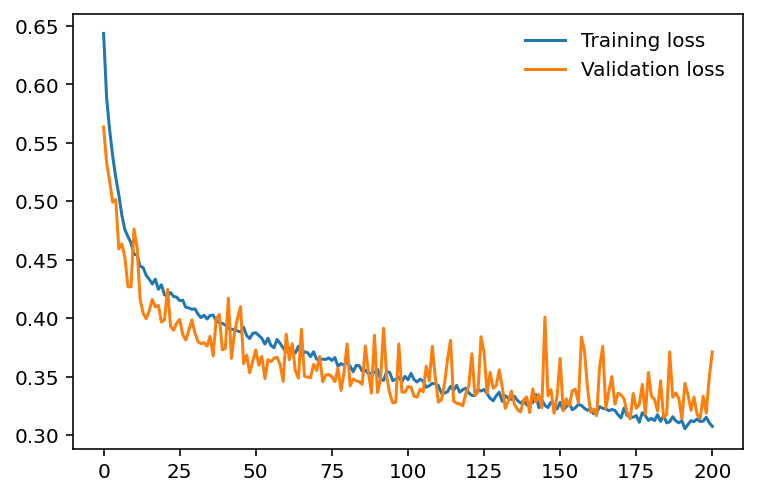

In [105]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

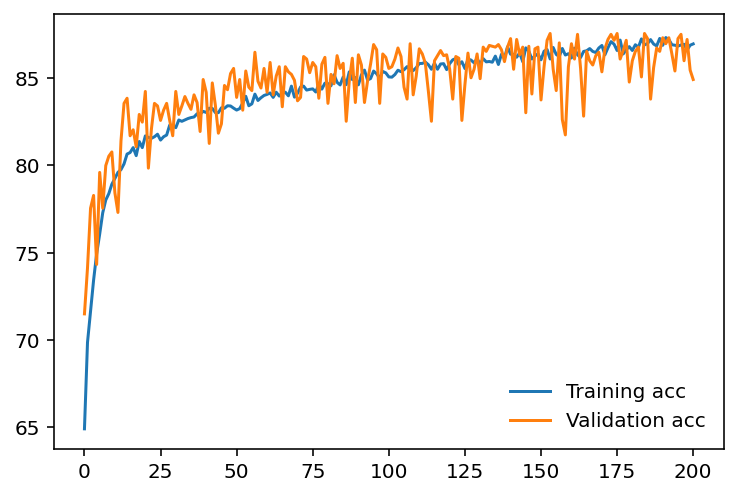

In [106]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_accs, label='Training acc')
plt.plot(valid_accs, label='Validation acc')
plt.legend(frameon=False)

In [80]:
from google.colab import files
files.download('model.pt')
files.download('training.csv')
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load('model.pt'))
# track test loss
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(len(data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

TP = class_correct[1]
TN = class_correct[0]
FP = class_total[0] - class_correct[0] 
FN = class_total[1] - class_correct[1]
ACC = (TP + TN)/(TP + TN + FP + FN)
PPV = TP/(TP+FP)
TPR = TP/(TP+FN)
F1 = 2*(PPV*TPR)/(PPV+TPR)
print("ACC = {:.4f}".format(ACC))
print("F1 = {:.4f}".format(F1))
print("PPV = {:.4f}".format(PPV))
print("TPR = {:.4f}".format(TPR))

Test Loss: 0.344130

Test Accuracy of Benign: 87% (868/996)
Test Accuracy of Malware: 83% (832/996)

Test Accuracy (Overall): 85% (1700/1992)
ACC = 0.8534
F1 = 0.8507
PPV = 0.8667
TPR = 0.8353
